1) XGboost Model


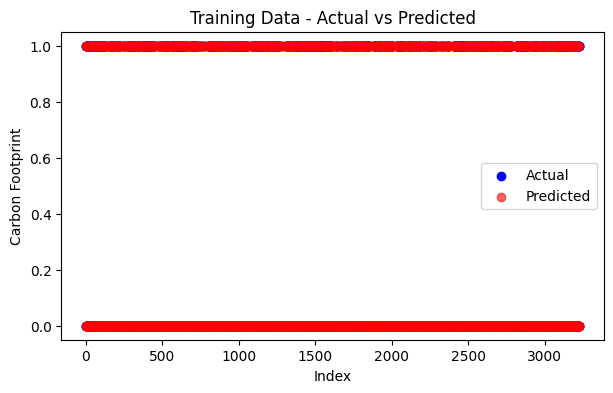

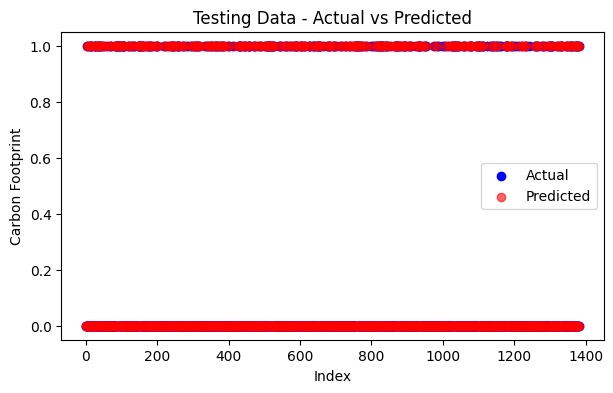

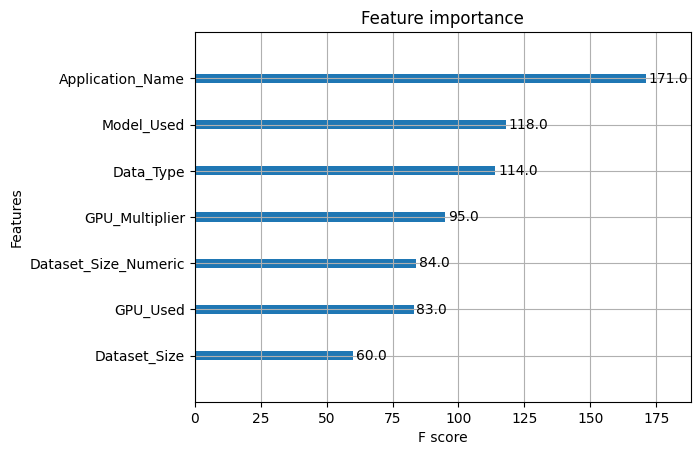

<Figure size 700x400 with 0 Axes>


=== Training Data Metrics ===
F1 Score: 0.9339
Recall: 0.9365
Optimized Accuracy: 93.65%
Precision: 0.9376

=== Testing Data Metrics ===
F1 Score: 0.9047
Recall: 0.9089
Optimized Accuracy: 90.89%
Precision: 0.9083


In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    log_loss, brier_score_loss
)
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Load the cleaned dataset
file_path = "/content/Carbon_Footprint.csv"  # Update this if needed
df = pd.read_csv(file_path)

# Specify the target column
target_column = 'Carbon_Footprint'  # Change this to your actual target column name

# Remove high-correlation features that may cause data leakage
features_to_drop = [
    "Carbon_Emission", "ES_Multiplier", "Power_Consumption", "Training_Time", "Electricity_Source",
    "Data_Type_Multiplier", "Model_Multiplier", "Dataset_Size_Category",
    "Dataset_Size_Multiplier", "LM_Multiplier", "Dataset_Type_Multiplier",
    "Learning_Method", "Dataset_Type"
]

df = df.drop(columns=features_to_drop, errors='ignore')

# Remove duplicate rows before splitting
df = df.drop_duplicates()

# Encode categorical features
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    if col != target_column:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# Encode target column if it's categorical
if df[target_column].dtype == 'object':
    target_le = LabelEncoder()
    df[target_column] = target_le.fit_transform(df[target_column])

# Split the dataset into training and testing sets
X = df.drop(columns=[target_column]).drop_duplicates()
y = df[target_column].loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True
)

model = xgb.XGBClassifier(
    eval_metric='logloss',
    n_estimators=50,
    early_stopping_rounds=10,
    tree_method='hist',
    subsample=0.7,
    colsample_bytree=0.7,
    max_depth=4,
    reg_alpha=0.3,
    reg_lambda=0.3
)

# Train with validation set for early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Make class predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Make probability predictions
y_train_proba = model.predict_proba(X_train)
y_test_proba = model.predict_proba(X_test)

# Compute classification metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')

test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')

# Compute Log Loss
train_log_loss = log_loss(y_train, y_train_proba)
test_log_loss = log_loss(y_test, y_test_proba)

# Compute Brier Score (binary classification only)
if y_train_proba.shape[1] == 2:
    train_brier_score = brier_score_loss(y_train, y_train_proba[:, 1])
    test_brier_score = brier_score_loss(y_test, y_test_proba[:, 1])
else:
    train_brier_score = "N/A (only for binary classification)"
    test_brier_score = "N/A (only for binary classification)"

# Create DataFrame for actual vs predicted values
train_results_df = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
test_results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# Plot Actual vs Predicted (Training Data)
plt.figure(figsize=(7, 4))
plt.scatter(range(len(y_train)), y_train, color='blue', label='Actual')
plt.scatter(range(len(y_train_pred)), y_train_pred, color='red', alpha=0.6, label='Predicted')
plt.xlabel("Index")
plt.ylabel("Carbon Footprint")
plt.title("Training Data - Actual vs Predicted")
plt.legend()
plt.show()

# Plot Actual vs Predicted (Testing Data)
plt.figure(figsize=(7, 4))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(y_test_pred)), y_test_pred, color='red', alpha=0.6, label='Predicted')
plt.xlabel("Index")
plt.ylabel("Carbon Footprint")
plt.title("Testing Data - Actual vs Predicted")
plt.legend()
plt.show()

# Feature Importance Plot
xgb.plot_importance(model)
plt.figure(figsize=(7, 4))
plt.show()

# Print evaluation metrics
print("\n=== Training Data Metrics ===")
print(f'F1 Score: {train_f1:.4f}')
print(f'Recall: {train_recall:.4f}')
print(f'Optimized Accuracy: {train_accuracy * 100:.2f}%')
print(f'Precision: {train_precision:.4f}')

print("\n=== Testing Data Metrics ===")
print(f'F1 Score: {test_f1:.4f}')
print(f'Recall: {test_recall:.4f}')
print(f'Optimized Accuracy: {test_accuracy * 100:.2f}%')
print(f'Precision: {test_precision:.4f}')


a) Probability based metrix

In [ ]:
print("\n=== Probability-Based Metrics (Training) ===")
print(f'Log Loss (Train): {train_log_loss:.4f}')
print(f'Brier Score (Train): {train_brier_score}')

print("\n=== Probability-Based Metrics (Testing) ===")
print(f'Log Loss (Test): {test_log_loss:.4f}')
print(f'Brier Score (Test): {test_brier_score}')


=== Probability-Based Metrics (Training) ===
Log Loss (Train): 0.5405
Brier Score (Train): 0.05357407529828146

=== Probability-Based Metrics (Testing) ===
Log Loss (Test): 0.5448
Brier Score (Test): 0.07127548166977936


b) Class Imbalance Metrics


=== Class Imbalance Metrics - Training Data ===
Balanced Accuracy : 0.5000
Macro F1 Score     : 0.4324
Cohen’s Kappa      : 0.0000
Matthews CorrCoef  : 0.0000

=== Class Imbalance Metrics - Testing Data ===
Balanced Accuracy : 0.5000
Macro F1 Score     : 0.4307
Cohen’s Kappa      : 0.0000
Matthews CorrCoef  : 0.0000


<Figure size 600x500 with 0 Axes>

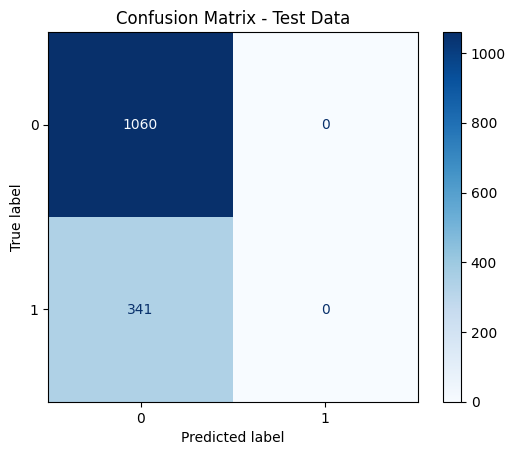

In [ ]:
from sklearn.metrics import (
    balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef,
    confusion_matrix, ConfusionMatrixDisplay
)

# Additional class imbalance-specific metrics
train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_pred)
test_balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)

train_macro_f1 = f1_score(y_train, y_train_pred, average='macro')
test_macro_f1 = f1_score(y_test, y_test_pred, average='macro')

train_cohen_kappa = cohen_kappa_score(y_train, y_train_pred)
test_cohen_kappa = cohen_kappa_score(y_test, y_test_pred)

train_mcc = matthews_corrcoef(y_train, y_train_pred)
test_mcc = matthews_corrcoef(y_test, y_test_pred)

# Print class imbalance metrics
print("\n=== Class Imbalance Metrics - Training Data ===")
print(f"Balanced Accuracy : {train_balanced_accuracy:.4f}")
print(f"Macro F1 Score     : {train_macro_f1:.4f}")
print(f"Cohen’s Kappa      : {train_cohen_kappa:.4f}")
print(f"Matthews CorrCoef  : {train_mcc:.4f}")

print("\n=== Class Imbalance Metrics - Testing Data ===")
print(f"Balanced Accuracy : {test_balanced_accuracy:.4f}")
print(f"Macro F1 Score     : {test_macro_f1:.4f}")
print(f"Cohen’s Kappa      : {test_cohen_kappa:.4f}")
print(f"Matthews CorrCoef  : {test_mcc:.4f}")

# Confusion matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Data")
plt.show()


c) Multi-Class Metrics

In [ ]:
from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score,
    hamming_loss, jaccard_score, confusion_matrix, ConfusionMatrixDisplay
)
# Standard metrics
print("\n=== Multi-Class Metrics: Training Data ===")
print(f"Accuracy           : {accuracy_score(y_train, y_train_pred):.4f}")
print(f"F1 Score (macro)   : {f1_score(y_train, y_train_pred, average='macro'):.4f}")
print(f"F1 Score (micro)   : {f1_score(y_train, y_train_pred, average='micro'):.4f}")
print(f"F1 Score (weighted): {f1_score(y_train, y_train_pred, average='weighted'):.4f}")
print(f"Precision (macro)  : {precision_score(y_train, y_train_pred, average='macro'):.4f}")
print(f"Recall (macro)     : {recall_score(y_train, y_train_pred, average='macro'):.4f}")
print(f"Hamming Loss       : {hamming_loss(y_train, y_train_pred):.4f}")
print(f"Jaccard Score      : {jaccard_score(y_train, y_train_pred, average='macro'):.4f}")

print("\n=== Multi-Class Metrics: Testing Data ===")
print(f"Accuracy           : {accuracy_score(y_test, y_test_pred):.4f}")
print(f"F1 Score (macro)   : {f1_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"F1 Score (micro)   : {f1_score(y_test, y_test_pred, average='micro'):.4f}")
print(f"F1 Score (weighted): {f1_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"Precision (macro)  : {precision_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"Recall (macro)     : {recall_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"Hamming Loss       : {hamming_loss(y_test, y_test_pred):.4f}")
print(f"Jaccard Score      : {jaccard_score(y_test, y_test_pred, average='macro'):.4f}")



=== Multi-Class Metrics: Training Data ===
Accuracy           : 0.7617
F1 Score (macro)   : 0.4324
F1 Score (micro)   : 0.7617
F1 Score (weighted): 0.6587
Precision (macro)  : 0.3809
Recall (macro)     : 0.5000
Hamming Loss       : 0.2383
Jaccard Score      : 0.3809

=== Multi-Class Metrics: Testing Data ===
Accuracy           : 0.7566
F1 Score (macro)   : 0.4307
F1 Score (micro)   : 0.7566
F1 Score (weighted): 0.6518
Precision (macro)  : 0.3783
Recall (macro)     : 0.5000
Hamming Loss       : 0.2434
Jaccard Score      : 0.3783


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


d) Confusion matrix

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Sample training
model = XGBClassifier()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Optional: Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[1046   14]
 [  15  326]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1060
           1       0.96      0.96      0.96       341

    accuracy                           0.98      1401
   macro avg       0.97      0.97      0.97      1401
weighted avg       0.98      0.98      0.98      1401



e) Curve-Based Metrics

ROC AUC Score: 0.9994368530258044


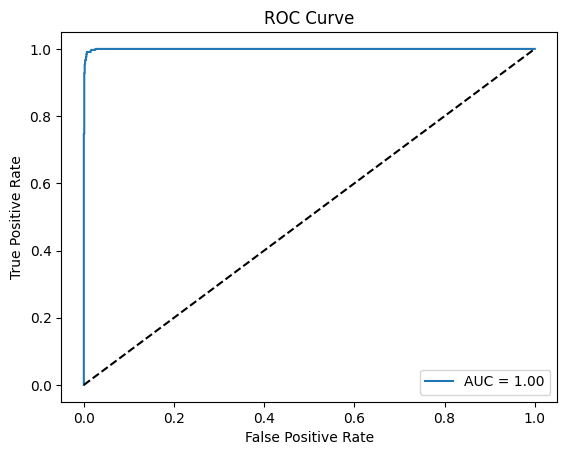

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predicted probabilities
y_probs = model.predict_proba(X_test)[:, 1]  # Probability for class 1

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_probs)
print("ROC AUC Score:", roc_auc)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


2) Logestic Regression


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Training Metrics ===
Accuracy       : 76.17%
F1 Score       : 0.6587
Precision      : 0.5802
Recall         : 0.7617
Log Loss       : 0.5405
Brier Score    : 0.1786

=== Testing Metrics ===
Accuracy       : 75.66%
F1 Score       : 0.6518
Precision      : 0.5724
Recall         : 0.7566
Log Loss       : 0.5448
Brier Score    : 0.1806


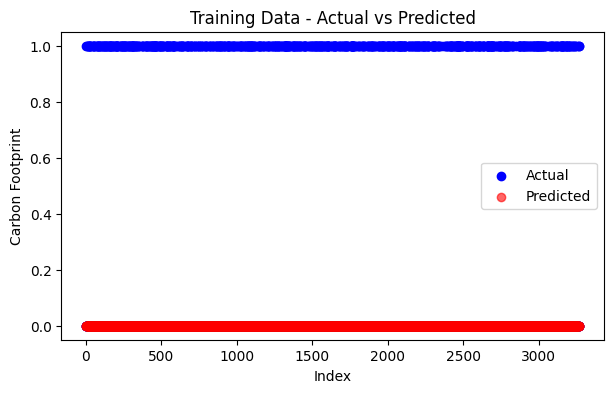

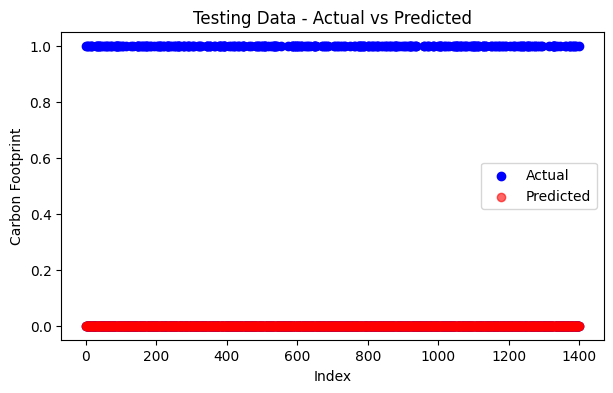

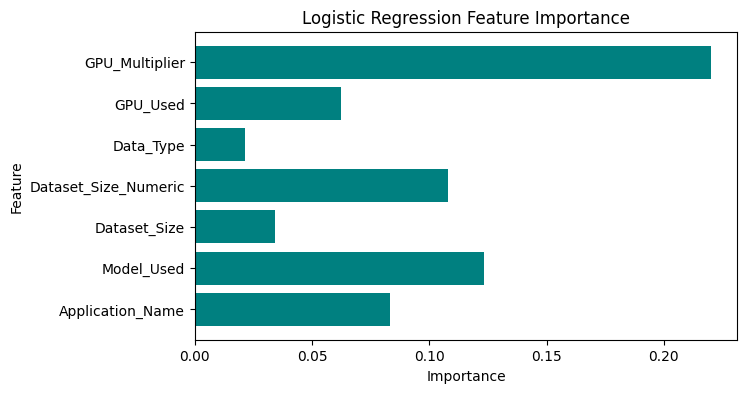

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    log_loss, brier_score_loss
)

# Load the cleaned dataset
file_path = "/content/Carbon_Footprint.csv"
df = pd.read_csv(file_path)

# Specify the target column
target_column = 'Carbon_Footprint'

# Remove features that may cause leakage
features_to_drop = [
    "Carbon_Emission", "ES_Multiplier", "Power_Consumption", "Training_Time", "Electricity_Source",
    "Data_Type_Multiplier", "Model_Multiplier", "Dataset_Size_Category",
    "Dataset_Size_Multiplier", "LM_Multiplier", "Dataset_Type_Multiplier",
    "Learning_Method", "Dataset_Type"
]
df = df.drop(columns=features_to_drop, errors='ignore')
df = df.drop_duplicates()

# Encode categorical features
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    if col != target_column:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# Encode target if needed
if df[target_column].dtype == 'object':
    target_le = LabelEncoder()
    df[target_column] = target_le.fit_transform(df[target_column])

# Train/test split
X = df.drop(columns=[target_column])
y = df[target_column]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True
)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Probabilities
y_train_proba = model.predict_proba(X_train)
y_test_proba = model.predict_proba(X_test)

# Metrics - Training
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_log_loss = log_loss(y_train, y_train_proba)
train_brier = brier_score_loss(y_train, y_train_proba[:, 1]) if len(np.unique(y_train)) == 2 else np.nan

# Metrics - Testing
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_log_loss = log_loss(y_test, y_test_proba)
test_brier = brier_score_loss(y_test, y_test_proba[:, 1]) if len(np.unique(y_test)) == 2 else np.nan

# Print results
print("\n=== Training Metrics ===")
print(f"Accuracy       : {train_accuracy * 100:.2f}%")
print(f"F1 Score       : {train_f1:.4f}")
print(f"Precision      : {train_precision:.4f}")
print(f"Recall         : {train_recall:.4f}")

print("\n=== Testing Metrics ===")
print(f"Accuracy       : {test_accuracy * 100:.2f}%")
print(f"F1 Score       : {test_f1:.4f}")
print(f"Precision      : {test_precision:.4f}")
print(f"Recall         : {test_recall:.4f}")

# Actual vs Predicted Plot - Train
plt.figure(figsize=(7, 4))
plt.scatter(range(len(y_train)), y_train, color='blue', label='Actual')
plt.scatter(range(len(y_train_pred)), y_train_pred, color='red', alpha=0.6, label='Predicted')
plt.title("Training Data - Actual vs Predicted")
plt.xlabel("Index")
plt.ylabel("Carbon Footprint")
plt.legend()
plt.show()

# Actual vs Predicted Plot - Test
plt.figure(figsize=(7, 4))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(y_test_pred)), y_test_pred, color='red', alpha=0.6, label='Predicted')
plt.title("Testing Data - Actual vs Predicted")
plt.xlabel("Index")
plt.ylabel("Carbon Footprint")
plt.legend()
plt.show()

# Feature importance (coefficients)
feature_importance = np.abs(model.coef_[0])
feature_names = X.columns
plt.figure(figsize=(7, 4))
plt.barh(feature_names, feature_importance, color='teal')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Logistic Regression Feature Importance")
plt.show()


a) Probability based matrixs

In [ ]:
print("\n=== Training Metrics ===")
print(f"Log Loss       : {train_log_loss:.4f}")
print(f"Brier Score    : {train_brier:.4f}")

print("\n=== Testing Metrics ===")
print(f"Log Loss       : {test_log_loss:.4f}")
print(f"Brier Score    : {test_brier:.4f}")


=== Training Metrics ===
Log Loss       : 0.2004
Brier Score    : 0.1786

=== Testing Metrics ===
Log Loss       : 0.2436
Brier Score    : 0.1806


b) Multi-Class Metrics

In [ ]:
from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score,
    hamming_loss, jaccard_score, confusion_matrix, ConfusionMatrixDisplay
)
# === Multi-Class Metrics for Training Data ===
print("\n=== Multi-Class Metrics: Training Data ===")
print(f"Accuracy           : {accuracy_score(y_train, y_train_pred):.4f}")
print(f"F1 Score (macro)   : {f1_score(y_train, y_train_pred, average='macro'):.4f}")
print(f"F1 Score (micro)   : {f1_score(y_train, y_train_pred, average='micro'):.4f}")
print(f"F1 Score (weighted): {f1_score(y_train, y_train_pred, average='weighted'):.4f}")
print(f"Precision (macro)  : {precision_score(y_train, y_train_pred, average='macro'):.4f}")
print(f"Recall (macro)     : {recall_score(y_train, y_train_pred, average='macro'):.4f}")
print(f"Hamming Loss       : {hamming_loss(y_train, y_train_pred):.4f}")
print(f"Jaccard Score      : {jaccard_score(y_train, y_train_pred, average='macro'):.4f}")

# === Multi-Class Metrics for Testing Data ===
print("\n=== Multi-Class Metrics: Testing Data ===")
print(f"Accuracy           : {accuracy_score(y_test, y_test_pred):.4f}")
print(f"F1 Score (macro)   : {f1_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"F1 Score (micro)   : {f1_score(y_test, y_test_pred, average='micro'):.4f}")
print(f"F1 Score (weighted): {f1_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"Precision (macro)  : {precision_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"Recall (macro)     : {recall_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"Hamming Loss       : {hamming_loss(y_test, y_test_pred):.4f}")
print(f"Jaccard Score      : {jaccard_score(y_test, y_test_pred, average='macro'):.4f}")



=== Multi-Class Metrics: Training Data ===
Accuracy           : 0.7617
F1 Score (macro)   : 0.4324
F1 Score (micro)   : 0.7617
F1 Score (weighted): 0.6587
Precision (macro)  : 0.3809
Recall (macro)     : 0.5000
Hamming Loss       : 0.2383
Jaccard Score      : 0.3809

=== Multi-Class Metrics: Testing Data ===
Accuracy           : 0.7566
F1 Score (macro)   : 0.4307
F1 Score (micro)   : 0.7566
F1 Score (weighted): 0.6518
Precision (macro)  : 0.3783
Recall (macro)     : 0.5000
Hamming Loss       : 0.2434
Jaccard Score      : 0.3783


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


c) Confusion matrics

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Train the model
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

# Make predictions
y_pred = log_model.predict(X_test)

# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Optional: Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[1051    0]
 [ 332    0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      1051
           1       0.00      0.00      0.00       332

    accuracy                           0.76      1383
   macro avg       0.38      0.50      0.43      1383
weighted avg       0.58      0.76      0.66      1383



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


d) Curve-Based Metrics

ROC AUC Score: 0.5933


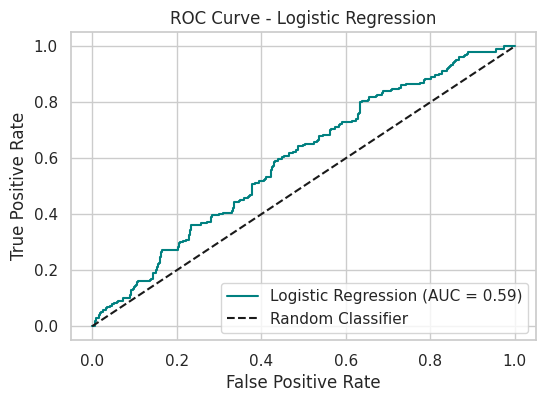

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: make plots look cleaner
sns.set(style="whitegrid")

# 1. Split your data (assuming X and y are already defined)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Train Logistic Regression model
log_model = LogisticRegression(solver='liblinear')  # 'liblinear' is good for binary classification
log_model.fit(X_train, y_train)

# 3. Predict probabilities
y_probs = log_model.predict_proba(X_test)[:, 1]  # Probability for class 1

# 4. ROC AUC Score
roc_auc = roc_auc_score(y_test, y_probs)
print(f"ROC AUC Score: {roc_auc:.4f}")

# 5. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# 6. Plot the ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.2f})", color='teal')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


e) Class imbalance-specific metrics


=== Class Imbalance Metrics - Training Data ===
Balanced Accuracy : 0.5000
Macro F1 Score     : 0.4324
Cohen’s Kappa      : 0.0000
Matthews CorrCoef  : 0.0000

=== Class Imbalance Metrics - Testing Data ===
Balanced Accuracy : 0.5000
Macro F1 Score     : 0.4307
Cohen’s Kappa      : 0.0000
Matthews CorrCoef  : 0.0000


<Figure size 600x500 with 0 Axes>

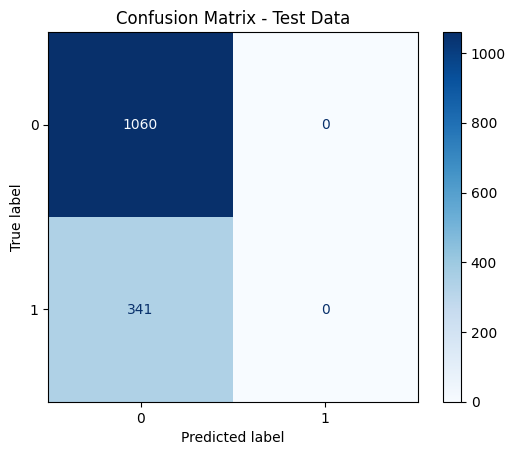

In [ ]:
from sklearn.metrics import (
    balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef,
    confusion_matrix, ConfusionMatrixDisplay
)
# Class imbalance-specific metrics

# Training data
train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_pred)
train_macro_f1 = f1_score(y_train, y_train_pred, average='macro')
train_cohen_kappa = cohen_kappa_score(y_train, y_train_pred)
train_mcc = matthews_corrcoef(y_train, y_train_pred)

# Testing data
test_balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
test_macro_f1 = f1_score(y_test, y_test_pred, average='macro')
test_cohen_kappa = cohen_kappa_score(y_test, y_test_pred)
test_mcc = matthews_corrcoef(y_test, y_test_pred)

# Print results
print("\n=== Class Imbalance Metrics - Training Data ===")
print(f"Balanced Accuracy : {train_balanced_accuracy:.4f}")
print(f"Macro F1 Score     : {train_macro_f1:.4f}")
print(f"Cohen’s Kappa      : {train_cohen_kappa:.4f}")
print(f"Matthews CorrCoef  : {train_mcc:.4f}")

print("\n=== Class Imbalance Metrics - Testing Data ===")
print(f"Balanced Accuracy : {test_balanced_accuracy:.4f}")
print(f"Macro F1 Score     : {test_macro_f1:.4f}")
print(f"Cohen’s Kappa      : {test_cohen_kappa:.4f}")
print(f"Matthews CorrCoef  : {test_mcc:.4f}")

# Confusion matrix for test data
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Data")
plt.show()
